In [2]:
import os
import tempfile
import numpy as np
# import keras
# from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras as keras
import gspread
import pandas as pd
from oauth2client.service_account import ServiceAccountCredentials
%matplotlib inline

In [2]:
import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [10]:
def add_regularization(model, regularizer=keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [11]:

MobileNetV3Small

NameError: name 'MobileNetV3Small' is not defined

In [12]:
my_mobilenet = tf.keras.applications.MobileNetV3Small()
# mobile = keras.applications.

In [13]:
mobile = add_regularization(my_mobilenet)
# mobile=my_mobilenet
mobile.summary()

C:\Users\babba\Anaconda3\envs\objectdetect\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
___________________________________________________________________________________

In [14]:
mobile.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
___________________________________________________________________________________

In [15]:
x = mobile.layers[-2].output
x= tf.keras.layers.Dropout(rate=0.5)(x)
predictions = Dense(9, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
______________________________________________________________________________________________

In [17]:
pixels = 224
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32
data_dir=r'D:\sesimic\data'
test_dir=r'D:\sesimic\data_b'

In [18]:


validation_gen = ImageDataGenerator(preprocessing_function = keras.applications.mobilenet_v3.preprocess_input,validation_split=.20)
data_aug=0
if data_aug:
    train_datagen = ImageDataGenerator(
    preprocessing_function = keras.applications.mobilenet_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=90,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    validation_split=.20) # set validation split
else:
    train_datagen=validation_gen
    

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    subset="training",
#     color_mode='grayscale'
)

validation_generator = validation_gen.flow_from_directory(
    data_dir, subset="validation",
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
#     color_mode='grayscale'
)

test_generator = validation_gen.flow_from_directory(
    test_dir,
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = False,
#     color_mode='grayscale'
)

Found 13284 images belonging to 9 classes.
Found 3312 images belonging to 9 classes.
Found 5778 images belonging to 9 classes.


In [22]:
train_generator.n/BATCH_SIZE

415.125

In [97]:
my_callbacks = [
#     EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
    ModelCheckpoint(filepath='./Model/Check Point/model_SGD.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=1,
                    save_best_only=True,
                    save_weights_only=False
                   ),
#     TensorBoard(log_dir='../Log/tensorboard/'),
]

model.compile(SGD(learning_rate=.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )

In [98]:
%%time
model_history = model.fit(
    train_generator, # steps_per_epoch=1000, # training set / batch_size
    validation_data=validation_generator, # validation_steps=94, # validation set / batch_size
    epochs=100,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/100
416/416 [==============================] - 253s 582ms/step - loss: 0.3943 - accuracy: 0.9988 - val_loss: 0.6067 - val_accuracy: 0.9589

Epoch 00001: val_accuracy improved from -inf to 0.95894, saving model to ./Model/Check Point\model_SGD.01-0.61-0.96.h5


C:\Users\babba\Anaconda3\envs\objectdetect\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
416/416 [==============================] - 197s 474ms/step - loss: 0.3937 - accuracy: 0.9986 - val_loss: 0.6251 - val_accuracy: 0.9571

Epoch 00002: val_accuracy did not improve from 0.95894
Epoch 3/100
416/416 [==============================] - 197s 474ms/step - loss: 0.3939 - accuracy: 0.9986 - val_loss: 0.6366 - val_accuracy: 0.9574

Epoch 00003: val_accuracy did not improve from 0.95894
Epoch 4/100
416/416 [==============================] - 197s 474ms/step - loss: 0.3930 - accuracy: 0.9989 - val_loss: 0.6447 - val_accuracy: 0.9559

Epoch 00004: val_accuracy did not improve from 0.95894
Epoch 5/100
416/416 [==============================] - 197s 474ms/step - loss: 0.3933 - accuracy: 0.9991 - val_loss: 0.6496 - val_accuracy: 0.9550

Epoch 00005: val_accuracy did not improve from 0.95894
Epoch 6/100
416/416 [==============================] - 198s 475ms/step - loss: 0.3928 - accuracy: 0.9992 - val_loss: 0.6526 - val_accuracy: 0.9538

Epoch 00006: val_accuracy did not improv

416/416 [==============================] - 81s 196ms/step - loss: 0.3923 - accuracy: 0.9995 - val_loss: 0.6452 - val_accuracy: 0.9559

Epoch 00042: val_accuracy did not improve from 0.95894
Epoch 43/100
416/416 [==============================] - 81s 196ms/step - loss: 0.3922 - accuracy: 0.9993 - val_loss: 0.6460 - val_accuracy: 0.9559

Epoch 00043: val_accuracy did not improve from 0.95894
Epoch 44/100
416/416 [==============================] - 81s 196ms/step - loss: 0.3915 - accuracy: 0.9993 - val_loss: 0.6455 - val_accuracy: 0.9559

Epoch 00044: val_accuracy did not improve from 0.95894
Epoch 45/100
416/416 [==============================] - 83s 198ms/step - loss: 0.3915 - accuracy: 0.9996 - val_loss: 0.6453 - val_accuracy: 0.9553

Epoch 00045: val_accuracy did not improve from 0.95894
Epoch 46/100
416/416 [==============================] - 84s 202ms/step - loss: 0.3921 - accuracy: 0.9995 - val_loss: 0.6488 - val_accuracy: 0.9553

Epoch 00046: val_accuracy did not improve from 0.9589

416/416 [==============================] - 81s 195ms/step - loss: 0.3915 - accuracy: 0.9994 - val_loss: 0.6395 - val_accuracy: 0.9559

Epoch 00082: val_accuracy did not improve from 0.95894
Epoch 83/100
416/416 [==============================] - 82s 196ms/step - loss: 0.3910 - accuracy: 0.9998 - val_loss: 0.6395 - val_accuracy: 0.9556

Epoch 00083: val_accuracy did not improve from 0.95894
Epoch 84/100
416/416 [==============================] - 83s 200ms/step - loss: 0.3909 - accuracy: 0.9997 - val_loss: 0.6399 - val_accuracy: 0.9553

Epoch 00084: val_accuracy did not improve from 0.95894
Epoch 85/100
416/416 [==============================] - 83s 199ms/step - loss: 0.3907 - accuracy: 0.9997 - val_loss: 0.6389 - val_accuracy: 0.9556

Epoch 00085: val_accuracy did not improve from 0.95894
Epoch 86/100
416/416 [==============================] - 82s 198ms/step - loss: 0.3912 - accuracy: 0.9995 - val_loss: 0.6394 - val_accuracy: 0.9553

Epoch 00086: val_accuracy did not improve from 0.9589

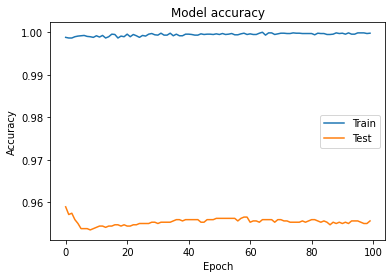

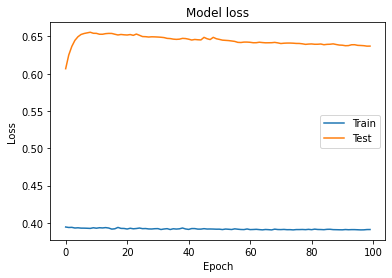

In [99]:
# Plot training & validation accuracy values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
# plt.savefig("mobile_net_v2_PA_acc.jpg",bbox_inches='tight')
plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
# plt.savefig("mobile_net_v2_PA_loss.jpg",bbox_inches='tight')
plt.show()

In [76]:
model_test=model.load_weights('./Model/Check Point/model.97-0.61-0.96.h5')

In [79]:
model.evaluate(test_generator, verbose=1)

181/181 [==============================] - 48s 241ms/step - loss: 3.1079 - accuracy: 0.7501


[3.1079471111297607, 0.7500865459442139]

In [80]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color='white' if cm[i,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [81]:
test_label = test_generator.classes
test_label

array([0, 0, 0, ..., 8, 8, 8])

In [82]:
test_prediction = model.predict(test_generator, verbose=1)

181/181 [==============================] - 6s 30ms/step


In [83]:
cm = confusion_matrix(test_label, test_prediction.argmax(axis=1))

confusion matrix, without normalization
[[511  30   4  16  11  20  13  22  15]
 [173 467   0   0   0   0   0   1   1]
 [ 17   1 596  24   0   4   0   0   0]
 [ 94   0   1 534   8   1   0   0   4]
 [ 84   8   0   5 492  48   1   0   4]
 [214   4   0  14   9 388   1   2  10]
 [241   0   0   0   1   1 374   7  18]
 [ 93   5   0   0   2   0   5 492  45]
 [124   0   0   0   2   7   0  29 480]]


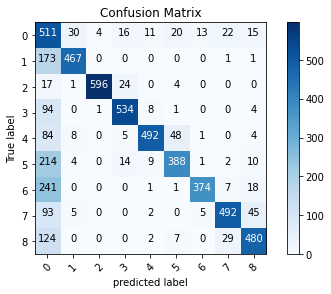

In [84]:
cm_plot_labels = [str(x) for x in range(9)]
confusion=plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# saving to googlesheet

In [3]:
# define the scope
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

# add credentials to the account
creds = ServiceAccountCredentials.from_json_keyfile_name('./Archive/sheet-323105-bb560576eed3.json', scope)

# authorize the clientsheet 
client = gspread.authorize(creds)

In [5]:
# get the instance of the Spreadsheet
sheet = client.open('Seismic training')

# get the first sheet of the Spreadsheet
sheet_instance = sheet.get_worksheet(0)

In [6]:
records_data = sheet_instance.get_all_records()


In [100]:
data={'Model Name':'mobilenetv2','Data Augmentation':'True','[Pixels, Pixels]':str(IMAGE_SIZE),'Training Set':train_generator.n
      ,'Test Set':test_generator.n,'Batch Size':BATCH_SIZE,'Epochs':50,'Steps Per Epoch':train_generator.n/BATCH_SIZE,
      'Time taken':'1 hour','Training loss':0.3943,'Training Acc':0.9988,'Validation loss':0.6067,
      'Validation Acc':0.9589,'Change implemented':'first iteration'}
data=pd.DataFrame(data,index=(0,))

In [72]:
loss: 0.3943 - accuracy: 0.9988 - val_loss: 0.6067 - val_accuracy: 0.9589

,Model Name,Data Augmentation,"[Pixels, Pixels]",Training Set,Test Set,Batch Size,Epochs,Steps Per Epoch,Time taken,Training loss,Training Acc,Validation loss,Validation Acc,Change implemented
0,mobilenetv2,True,"(224, 224)",13284,5778,32,50,415.125,1 hour,0.389,0.9995,0.7471,0.9293,first iteration


In [101]:
sheet_instance.insert_rows(data.values.tolist(),3)

{'spreadsheetId': '10zpFlZQ92Pg6uxo4gZyISGEMc3oTh2GT_ugk-pZP4mc',
 'updates': {'spreadsheetId': '10zpFlZQ92Pg6uxo4gZyISGEMc3oTh2GT_ugk-pZP4mc',
  'updatedRange': 'Sheet1!A3:N3',
  'updatedRows': 1,
  'updatedColumns': 14,
  'updatedCells': 14}}

In [95]:
dir(sheet_instance)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_finder',
 '_list_cells',
 '_properties',
 'acell',
 'add_cols',
 'add_protected_range',
 'add_rows',
 'append_row',
 'append_rows',
 'batch_clear',
 'batch_get',
 'batch_update',
 'cell',
 'clear',
 'clear_basic_filter',
 'clear_note',
 'client',
 'col_count',
 'col_values',
 'copy_to',
 'delete_columns',
 'delete_dimension',
 'delete_row',
 'delete_rows',
 'duplicate',
 'export',
 'find',
 'findall',
 'format',
 'freeze',
 'frozen_col_count',
 'frozen_row_count',
 'get',
 'get_all_records',
 'get_all_values',
 'get_note',
 'get_values',
 'id',
 'insert_cols',
 'insert_note',
 'insert_row',
 'insert_rows',
 'merge_cells